In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns

from world_machine_experiments.shared.save_metrics import load_multiple_metrics, get_values
from world_machine_experiments.toy1d.dimensions import Dimensions
from world_machine.train.stages import StateSaveMethod
from world_machine_experiments.shared.acronyms import format_name

In [2]:
metrics = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_metrics")
parameters = load_multiple_metrics("toy1d_experiment1_configuration_test", "parameters")
train_history = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_train_history")

In [3]:
list(metrics.keys()) == list(parameters.keys()), list(train_history.keys()) == list(metrics.keys())

(True, True)

In [70]:
names = np.array(list(metrics.keys()))
metric_names = ["normal", "use_state", "prediction", "prediction_shallow", "prediction_local"]

In [547]:
parameters_data = []

for name in parameters:
    item = parameters[name]["parameters"]
    item["name"] = name

    for m in metric_names:
        m_1 = m
        m_2 = m
        if m == "prediction_local":
            m_2 = "prediction_shallow"

        for criterion in ["mse", "0.1sdtw"]:
            item[f"{m_1}_{criterion}"] = metrics[name]["means"][m_2][f"state_decoded_{criterion}"]

    item["duration"] = train_history[name]["means"]["duration"].sum()
    
    parameters_data.append(item)

In [548]:
df = pd.DataFrame(parameters_data)

In [549]:
mask = np.ones(len(df), bool)
for metric in metric_names:
    if metric == "prediction_local":
        continue

    mask = np.bitwise_and(mask, np.bitwise_not(df[metric+"_mse"].isna()))

    data = df[f"{metric}_mse"].to_numpy()

    data_mask = np.bitwise_not(np.isnan(data))
    data_mask = np.bitwise_and(data_mask, data<1)
    
    data_max = data[data_mask].mean() + 3*data[data_mask].std()
    
    mask = np.bitwise_and(mask, np.bitwise_not(np.isnan(data)))
    mask = np.bitwise_and(mask, data<data_max)

mask.sum()

3070

In [550]:
for metric in metric_names:
    df[f"normalized_{metric}_mse"] = (df[f"{metric}_mse"] - df[mask][f"{metric}_mse"].mean()) / df[mask][f"{metric}_mse"].std()

In [551]:
df["mask"] = mask

In [552]:
df["SB_1"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == False)
df["SB_2"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == True)

df["SM_1"] = df["state_save_method"] == StateSaveMethod.MEAN.value
df["SM_2"] = df["check_input_masks"] == True

df["AC_1"] = pd.isnull(df["state_activation"])

df["MD_1"] = df["block_configuration"].map(lambda x : np.alltrue(x == [Dimensions.MEASUREMENT.value, Dimensions.STATE_INPUT.value]))

df["NA_1"] = df["noise_config"].map(lambda x: x is not None and "state" in x)
df["NA_2"] = df["noise_config"].map(lambda x: x is not None and "measurement" in x)

#df["ST_1"] = df["recall_stride_past"] == 1
#df["ST_2"] = df["recall_stride_past"] == 3
#df["ST_3"] = df["recall_n_past"] == 1
#df["ST_4"] = df["recall_n_past"] == 5
#df["ST_5"] = df["recall_n_future"] == 1
#df["ST_6"] = df["recall_n_future"] == 5

df["ST_1"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_past"] == 1)
df["ST_2"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_past"] == 5)
df["ST_3"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_past"] == 1)
df["ST_4"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_past"] == 5)

df["ST_5"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_future"] == 1)
df["ST_6"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_future"] == 5)
df["ST_7"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_future"] == 1)
df["ST_8"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_future"] == 5)


In [553]:
variables = ["SB_1", "SB_2", "SM_1", "SM_2", "AC_1", "MD_1", "NA_1", "NA_2", "ST_1", "ST_2", "ST_3", "ST_4", "ST_5", "ST_6", "ST_7", "ST_8"]

In [554]:
disjunt_groups = [{"ST_1", "ST_2", "ST_3", "ST_4"}, 
                  {"ST_5", "ST_6", "ST_7", "ST_8"}, 
                  {"ST_1", "ST_2", "ST_7", "ST_8"},
                  {"ST_3", "ST_4", "ST_5", "ST_6"},
                  {"SB_1", "SB_2"},
                  ]

In [627]:
def impact_test(df, variable, metric):
    x : pd.DataFrame = df[df[variable] == False]
    y : pd.DataFrame  = df[df[variable] == True]

    disjunt_vars = set()
    for group in disjunt_groups:
        if variable in group:
            disjunt_vars.update(group)

    for var in disjunt_vars:
        x = x[x[var]==False]

    for var in variables:
        if var == variable or var in disjunt_vars:
            continue
    
        x = x.sort_values(by=var, kind="stable")
        y = y.sort_values(by=var, kind="stable")

    x_mask = x["mask"].to_numpy()
    y_mask = y["mask"].to_numpy()
    mask = np.bitwise_and(x_mask, y_mask)
    
    x : np.ndarray = x[metric].to_numpy()
    y : np.ndarray = y[metric].to_numpy()
    
    x = x[mask]
    y = y[mask]
    
    result = wilcoxon(x, y, nan_policy="omit")
    
    diff = (y - x)
    diff = diff[np.bitwise_not(np.isnan(diff))]
    impact = diff.mean()
    impact_std = diff.std()

    return result.pvalue, impact, diff, impact_std

In [556]:
test_data = []
test_full_data = []

for var in variables:

    for task in metric_names:

        p_value, impact, diff = impact_test(df, var, f"{task}_mse")

        item = {"variable":var, "task":format_name(task)}
        item["p_value"] = p_value
        item["impact"] = impact

        test_data.append(item)

        for d in diff:
            item = item.copy()
            item["diff"] = d

            test_full_data.append(item) 

df_test = pd.DataFrame(test_data)
df_test_full = pd.DataFrame(test_full_data)

In [557]:
failed = df_test[df_test["p_value"]>=0.05]

In [558]:
mask_l = df_test_full["variable"] == "SB_1"
mask_l = np.bitwise_and(mask_l, df_test_full["task"] == "prediction_shallow")

In [559]:
metric_names

['normal', 'use_state', 'prediction', 'prediction_shallow', 'prediction_local']

In [560]:
metric_names_formatted = []
for m in metric_names:
    metric_names_formatted.append(format_name(m))

In [561]:
uncond_diverge_prob = 1-(mask.sum()/len(mask))
uncond_diverge_prob

diverge_prob = {}
for v in variables:
    prob = 1- (df[df[v]]["mask"].sum()/len(df[df[v]]))

    diverge_prob[v] = prob



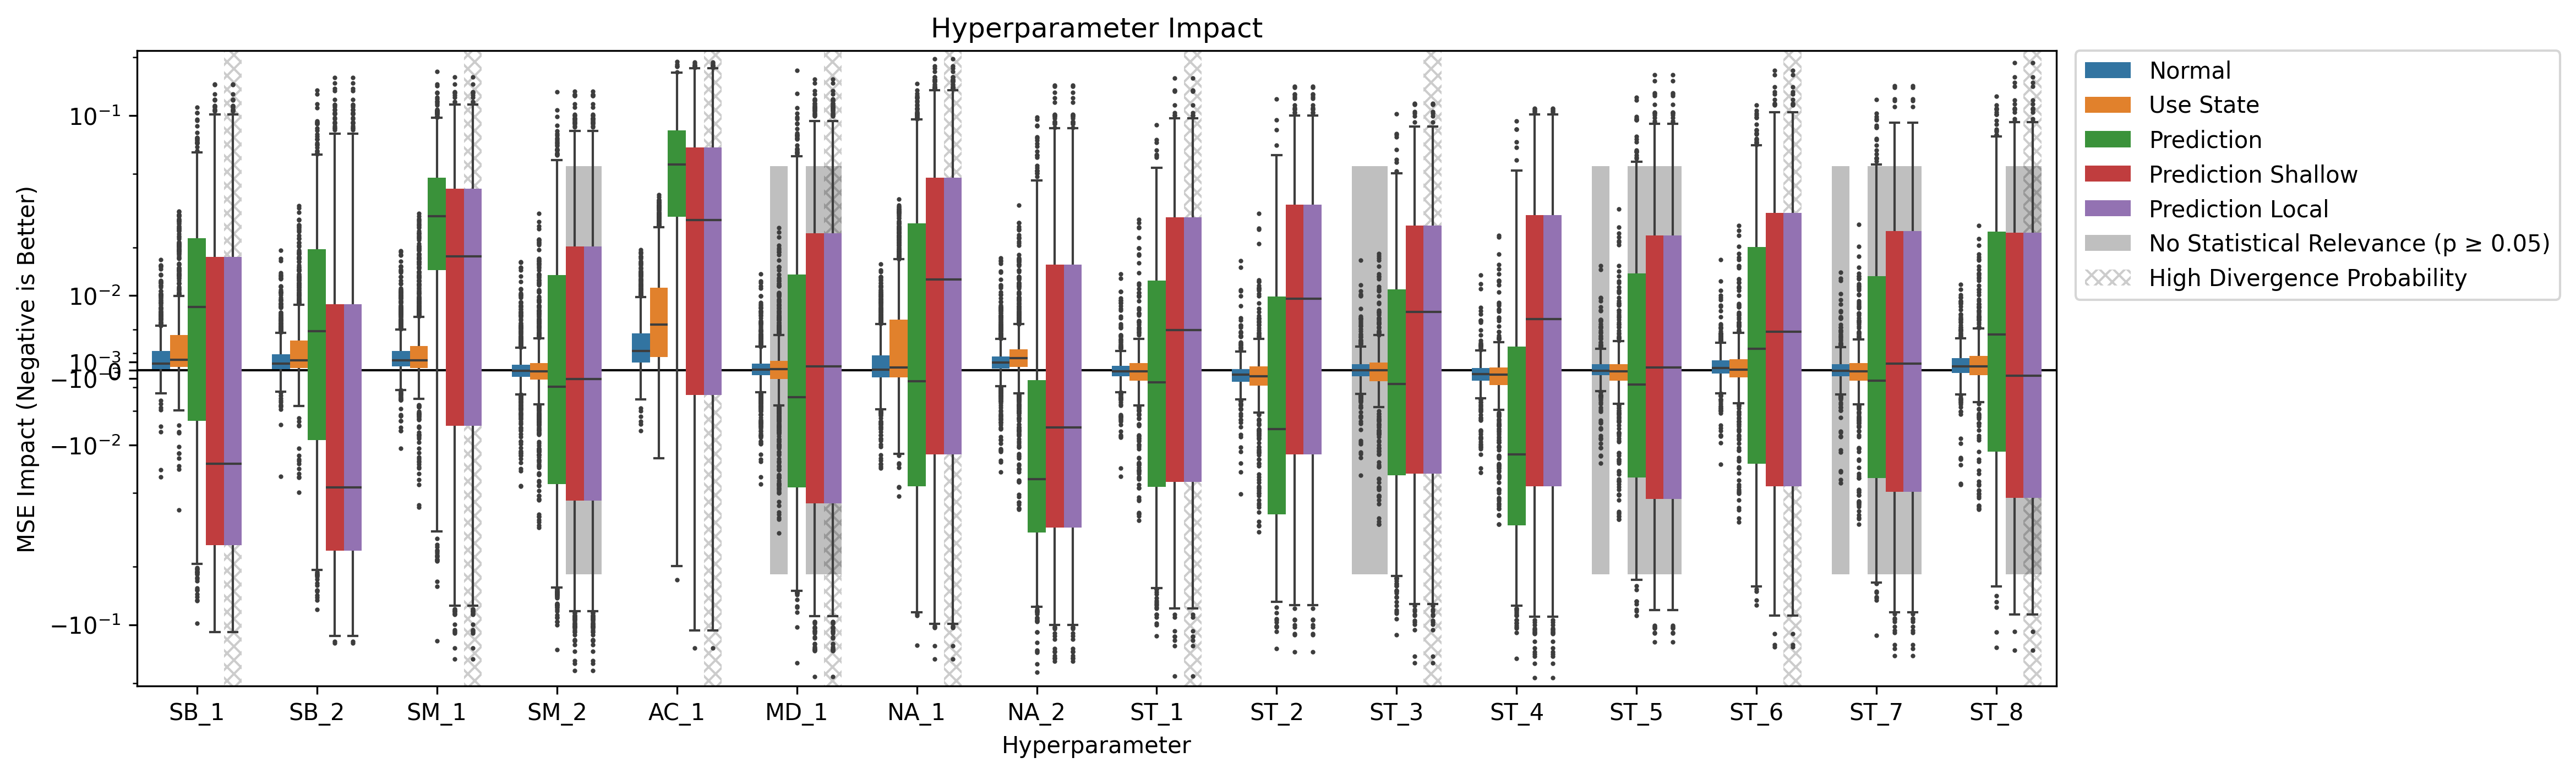

In [562]:
bar_width = 0.15

fig, ax = plt.subplots(dpi=300, figsize=(15, 5))

sns.boxplot(df_test_full, x="variable", y="diff", hue="task", ax=ax, width=5*bar_width, flierprops={"markersize":1},  boxprops={"edgecolor":'none'})
#sns.violinplot(df_test_full, x="variable", y="diff", hue="task", ax=ax, width=5*bar_width, inner=None)
#sns.barplot(df_test_full, x="variable", y="diff", hue="task", ax=ax, width=5*bar_width)#, flierprops={"markersize":1})


xlim = ax.get_xlim()
ylim = ax.get_ylim()

plt.hlines(0, xlim[0], xlim[1], color="black", lw=1, zorder=-1)

for i in range(len(failed)):
    variable = failed.iloc[i]["variable"]
    task = failed.iloc[i]["task"]

    index = variables.index(variable)
    
    task_offset = metric_names_formatted.index(task)
    task_offset -= 2
    task_offset *= bar_width

    index += task_offset


    label=None
    if i == 0:
        label = "No Statistical Relevance (p ≥ 0.05)"
    plt.bar([index, index],  y_lim, alpha=0.5, color="gray", width=bar_width, label=label, zorder=-2)

first = True
for variable in variables:
    if diverge_prob[variable] > uncond_diverge_prob:
        label=None
        if first:
            label = "High Divergence Probability"
            first = False

        index = variables.index(variable)
    
        task_offset = metric_names_formatted.index(task)
        task_offset -= 2
        task_offset *= bar_width

        index += task_offset

        plt.bar([index, index], ylim, alpha=0.2, color="black", width=bar_width, label=label, zorder=-1, hatch="xxxx", edgecolor="black", linewidth=0, fill=False)


ax.set_xlim(xlim)
ax.set_ylim(ylim)

#ax.set_ylim(-0.06, 0.06)

plt.yscale("asinh", linear_width=0.01)
plt.title("Hyperparameter Impact")
plt.ylabel("MSE Impact (Negative is Better)")
plt.xlabel("Hyperparameter")
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)



In [563]:
df_test["diverge"] = list(map(lambda var: diverge_prob[var] > uncond_diverge_prob, df_test["variable"]))

In [564]:
usefull = df_test["p_value"] < 0.05
usefull = np.bitwise_and(usefull, np.bitwise_not(df_test["diverge"]))
usefull = np.bitwise_and(usefull, df_test["impact"]<0)

In [565]:
df_tasks = []
for task, task_f in zip(metric_names, metric_names_formatted):

    df_task = df_test[df_test["task"] == task_f]
    df_task = df_task.drop("task", axis=1)
    df_task = df_task.rename(columns={"impact":f"{task}_impact", "p_value":f"{task}_p_value"})

    df_tasks.append(df_task)

In [566]:
df_merged = df_tasks[0]

for i in range(1, len(df_tasks)):
    df_merged = pd.merge(df_merged, df_tasks[i], on=["variable", "diverge"], how="outer")

df_merged

,variable,normal_p_value,normal_impact,diverge,use_state_p_value,use_state_impact,prediction_p_value,prediction_impact,prediction_shallow_p_value,prediction_shallow_impact,prediction_local_p_value,prediction_local_impact
0,AC_1,8.044085e-197,0.003177,True,1.633200e-209,0.007820,1.648560e-226,0.058477,1.847053e-98,0.034046,1.847053e-98,0.034046
1,MD_1,2.147733e-02,0.000033,True,4.380217e-01,-0.000224,1.784293e-04,-0.001866,4.475185e-01,0.000813,4.475185e-01,0.000813
2,NA_1,7.150146e-09,0.000714,True,1.976461e-36,0.003528,3.225731e-03,0.006073,2.426552e-43,0.020015,2.426552e-43,0.020015
3,NA_2,9.482794e-103,0.001008,False,3.591104e-94,0.001582,4.037124e-107,-0.017342,2.540638e-15,-0.007640,2.540638e-15,-0.007640
4,SB_1,1.632228e-90,0.001624,True,4.404835e-107,0.003583,1.136456e-22,0.008032,2.137662e-13,-0.008924,2.137662e-13,-0.008924
5,SB_2,7.244094e-89,0.001411,False,5.106828e-102,0.002772,7.809878e-11,0.005323,3.004636e-33,-0.014983,3.004636e-33,-0.014983
6,SM_1,1.574768e-162,0.001731,True,1.035422e-116,0.002285,1.862776e-198,0.032218,9.204662e-58,0.016640,9.204662e-58,0.016640
7,SM_2,4.245768e-02,-0.000014,False,4.731882e-03,-0.000091,9.845432e-04,-0.002560,1.660257e-01,-0.001696,1.660257e-01,-0.001696
8,ST_1,3.554443e-02,-0.000046,True,1.278549e-02,-0.000553,1.954004e-02,-0.003940,2.427822e-03,0.004862,2.427822e-03,0.004862
9,ST_2,4.489669e-20,-0.000574,False,2.073940e-13,-0.001333,3.390902e-10,-0.008948,3.262734e-11,0.011695,3.262734e-11,0.011695


In [567]:
for metric in metric_names:
    df_merged.loc[df_merged[f"{metric}_p_value"] >= 0.05, f"{metric}_impact"] = 0

df_merged

,variable,normal_p_value,normal_impact,diverge,use_state_p_value,use_state_impact,prediction_p_value,prediction_impact,prediction_shallow_p_value,prediction_shallow_impact,prediction_local_p_value,prediction_local_impact
0,AC_1,8.044085e-197,0.003177,True,1.633200e-209,0.007820,1.648560e-226,0.058477,1.847053e-98,0.034046,1.847053e-98,0.034046
1,MD_1,2.147733e-02,0.000033,True,4.380217e-01,0.000000,1.784293e-04,-0.001866,4.475185e-01,0.000000,4.475185e-01,0.000000
2,NA_1,7.150146e-09,0.000714,True,1.976461e-36,0.003528,3.225731e-03,0.006073,2.426552e-43,0.020015,2.426552e-43,0.020015
3,NA_2,9.482794e-103,0.001008,False,3.591104e-94,0.001582,4.037124e-107,-0.017342,2.540638e-15,-0.007640,2.540638e-15,-0.007640
4,SB_1,1.632228e-90,0.001624,True,4.404835e-107,0.003583,1.136456e-22,0.008032,2.137662e-13,-0.008924,2.137662e-13,-0.008924
5,SB_2,7.244094e-89,0.001411,False,5.106828e-102,0.002772,7.809878e-11,0.005323,3.004636e-33,-0.014983,3.004636e-33,-0.014983
6,SM_1,1.574768e-162,0.001731,True,1.035422e-116,0.002285,1.862776e-198,0.032218,9.204662e-58,0.016640,9.204662e-58,0.016640
7,SM_2,4.245768e-02,-0.000014,False,4.731882e-03,-0.000091,9.845432e-04,-0.002560,1.660257e-01,0.000000,1.660257e-01,0.000000
8,ST_1,3.554443e-02,-0.000046,True,1.278549e-02,-0.000553,1.954004e-02,-0.003940,2.427822e-03,0.004862,2.427822e-03,0.004862
9,ST_2,4.489669e-20,-0.000574,False,2.073940e-13,-0.001333,3.390902e-10,-0.008948,3.262734e-11,0.011695,3.262734e-11,0.011695


In [568]:
usefull = np.bitwise_not(df_merged["diverge"])

usefull_to_any_other = np.zeros(len(df_merged), bool)
for metric in metric_names:
    if metric == "prediction_shallow":
        continue
    usefull_to_any_other = np.bitwise_or(usefull_to_any_other, df_merged[f"{metric}_impact"] < 0)

usefull = np.bitwise_and(usefull,  np.bitwise_or(df_merged["prediction_shallow_impact"] <= 0, np.bitwise_and(df_merged["prediction_shallow_impact"] == 0, usefull_to_any_other)))

In [569]:
df_merged[usefull]["variable"]

3     NA_2
5     SB_2
7     SM_2
12    ST_5
14    ST_7
Name: variable, dtype: object

In [616]:
def duration_test(df, variable):
    x : pd.DataFrame = df[df[variable] == False]
    y : pd.DataFrame  = df[df[variable] == True]

    disjunt_vars = set()
    for group in disjunt_groups:
        if variable in group:
            disjunt_vars.update(group)

    for var in disjunt_vars:
        x = x[x[var]==False]

    for var in variables:
        if var == variable or var in disjunt_vars:
            continue

        x = x.sort_values(by=var, kind="stable")
        y = y.sort_values(by=var, kind="stable")

    x_mask = x["mask"].to_numpy()
    y_mask = y["mask"].to_numpy()
    mask = np.bitwise_and(x_mask, y_mask)

    x : np.ndarray = x["duration"].to_numpy()
    y : np.ndarray = y["duration"].to_numpy()

    x = x[mask]
    y = y[mask]

    result = wilcoxon(x, y, nan_policy="omit")

    diff = (y - x)
    impact = diff[np.bitwise_not(np.isnan(diff))].mean()
    std = diff[np.bitwise_not(np.isnan(diff))].std()

    return result.pvalue, impact, std

In [629]:
for var in variables:
    p_value, duration_impact, duration_impact_std = duration_test(df, var)

    if p_value < 0.05:
        if np.sign(duration_impact-duration_impact_std) != np.sign(duration_impact+duration_impact_std):
            print(var, f"{duration_impact:.2f}+-{df[df[var]].duration.std():.2f}", f"{100*duration_impact/mean_duration:.2f}%", "AMBIGUOUS IMPACT")
        else:
            mean_duration = df[df[var]].duration.mean()
            print(var, f"{duration_impact:.2f}+-{df[df[var]].duration.std():.2f}", f"{100*duration_impact/mean_duration:.2f}%")
    else:
        print(var, "NO IMPACT")

SB_1 -1158.99+-647.02 -31.57%
SB_2 -1337.23+-401.46 -38.06%
SM_1 -215.34+-844.35 -6.13% AMBIGUOUS IMPACT
SM_2 -152.69+-936.80 -4.35% AMBIGUOUS IMPACT
AC_1 NO IMPACT
MD_1 -4.49+-894.74 -0.13% AMBIGUOUS IMPACT
NA_1 NO IMPACT
NA_2 NO IMPACT
ST_1 503.72+-754.94 14.34% AMBIGUOUS IMPACT
ST_2 1036.62+-919.50 23.12%
ST_3 372.94+-683.55 8.32% AMBIGUOUS IMPACT
ST_4 813.84+-837.11 18.15% AMBIGUOUS IMPACT
ST_5 439.22+-728.77 9.79% AMBIGUOUS IMPACT
ST_6 1022.72+-941.64 22.76%
ST_7 477.67+-706.01 10.63% AMBIGUOUS IMPACT
ST_8 996.37+-924.91 22.65%
